<a href="https://colab.research.google.com/github/MMathisLab/CEBRA-demos/blob/main/Demo_hippocampus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Encoding of space, hippocampus (CA1)

In this notebook, we show how to:

- use CEBRA on the hippocampus data.
- use the infoNCE loss with CEBRA.

More specifically, this is a notebook demonstrating the information presented in [Hypothesis-driven analysis](https://cebra.ai/docs/demo_notebooks/Demo_hypothesis_testing.html), [Consistency](https://cebra.ai/docs/demo_notebooks/Demo_consistency.html), [Decoding](https://cebra.ai/docs/demo_notebooks/Demo_decoding.html) and [Topological data analysis](https://cebra.ai/docs/demo_notebooks/Demo_cohomology.html) into a single demo notebook. We recommend that you go through those individual notebooks too for deeper informtion.

**Install note**

- Be sure you have demo dependencies installed to use this notebook:

In [ ]:
!pip install --pre 'cebra[dev,demos]'

In [2]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib as jl
import cebra.datasets
from cebra import CEBRA

from matplotlib.collections import LineCollection
import pandas as pd

### Load the data:

- The data will be automatically downloaded into a `/data` folder.

In [3]:
#1. Load example data
%mkdir data
hippocampus_pos = cebra.datasets.init('rat-hippocampus-single-achilles')

mkdir: cannot create directory ‘data’: File exists


### Visualize the data:

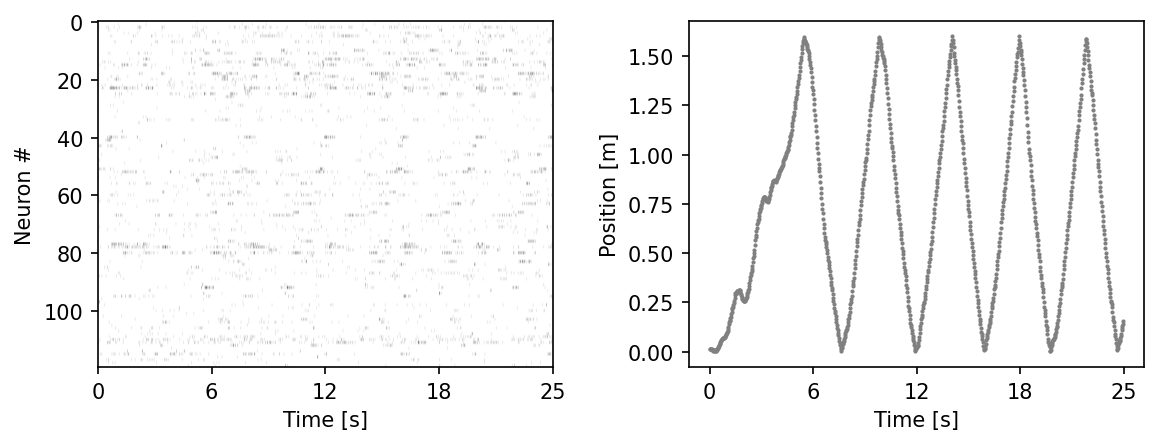

In [4]:
fig = plt.figure(figsize=(9,3), dpi=150)
plt.subplots_adjust(wspace = 0.3)
ax = plt.subplot(121)
ax.imshow(hippocampus_pos.neural.numpy()[:1000].T, aspect = 'auto', cmap = 'gray_r')
plt.ylabel('Neuron #')
plt.xlabel('Time [s]')
plt.xticks(np.linspace(0, 1000, 5), np.linspace(0, 0.025*1000, 5, dtype = int))

ax2 = plt.subplot(122)
ax2.scatter(np.arange(1000), hippocampus_pos.continuous_index[:1000,0], c = 'gray', s=1)
plt.ylabel('Position [m]')
plt.xlabel('Time [s]')
plt.xticks(np.linspace(0, 1000, 5), np.linspace(0, 0.025*1000, 5, dtype = int))
plt.show()

### CEBRA-Behavior: Train a model with 3D output that uses positional information (position + direction).

- Please be aware this is JUST a demo notebook; for details on reproducing our paper results, see the paper.
- Please see our [user docs](https://cebra.ai/docs/usage.html#quick-start-scikit-learn-api-example) for our suggestions on properly using CEBRA for experiments.
- Setting conditional = 'time_delta' means we will use CEBRA-Behavior mode and use auxiliary behavior variable for the model training.

- For a quick CPU run-time demo, you can drop `max_iterations` to 100-500; otherwise set to 5000.
- For reproducing Figure 2, we use dimension 3 for the infoNCE loss. You can otherwise set it higher.

In [5]:
max_iterations = 10000
output_dimension = 32 #here, we set as a variable for hypothesis testing below.

In [6]:
#2. Define the model
cebra_posdir3_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

Attention: Here we split the data for train/validation into 80/20. Note, the behavior might not be the same in the first 80% vs. last 20%, therefore, we recommend cross validating with different splitting strategies when when you use this feature! Read more at [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [7]:
# 3. Split data and labels
from sklearn.model_selection import train_test_split

(
    train_data,
    valid_data,
    train_continuous_label,
    valid_continuous_label,
) = train_test_split(hippocampus_pos.neural,
                    hippocampus_pos.continuous_index.numpy(),
                    test_size=0.2)

### We train the model with neural data and the behavior variable including position and direction.

- with a V100 GPU, 10K iterations should take less then 3 min.

In [8]:
# 4. Fit the model
cebra_posdir3_model.fit(train_data, train_continuous_label)

pos: -0.4709 neg:  6.5170 total:  6.0461 temperature:  1.0000: 100%|██████████| 10000/10000 [01:32<00:00, 108.55it/s]


CEBRA(batch_size=512, conditional='time_delta',
      model_architecture='offset10-model', output_dimension=3, temperature=1,
      time_offsets=10, verbose=True)

In [9]:
# 5. Save the model
import os
import tempfile
from pathlib import Path
tmp_file = Path(tempfile.gettempdir(), 'cebra.pt')
cebra_posdir3_model.save(tmp_file)

In [10]:
# 6. Load the model and compute an embedding
cebra_posdir3_model = cebra.CEBRA.load(tmp_file)
train_embedding = cebra_posdir3_model.transform(train_data)
valid_embedding = cebra_posdir3_model.transform(valid_data)


In [11]:
# 7. Evaluate the model performance on the validation set
goodness_of_fit = cebra.sklearn.metrics.infonce_loss(cebra_posdir3_model,
                                                     valid_data,
                                                     valid_continuous_label,
                                                     num_batches=5)
print(" goodness of fit - validation:",goodness_of_fit)

# Evaluate the model performance on the train set
goodness_of_fit = cebra.sklearn.metrics.infonce_loss(cebra_posdir3_model,
                                                     train_data,
                                                     train_continuous_label,
                                                     num_batches=5)
print(" goodness of fit - train:",goodness_of_fit)

100%|██████████| 5/5 [00:00<00:00, 253.06it/s]


 goodness of fit - validation: 6.191358947753907


100%|██████████| 5/5 [00:00<00:00, 274.97it/s]

 goodness of fit - train: 6.02918701171875


### Visualize the embedding
- Note, CEBRA's strength is quantitative measures of the resulting embedding with goodness of fit and consistency (comparisions across models, etc). But, it is useful to visualize the data for a qualitative assessment.
 - If it's collapsed or points are uniformly scattered across the sphere, either your label is not well represented in your data, or you need to adjust your model.

In [12]:
import cebra.integrations.plotly

fig = cebra.integrations.plotly.plot_embedding_interactive(train_embedding,
                                                           embedding_labels=train_continuous_label[:,0],
                                                           title = "CEBRA-Behavior Train",
                                                           markersize=2,
                                                           cmap = "rainbow")
fig.show()

<Figure size 500x500 with 0 Axes>

In [13]:
import cebra.integrations.plotly

fig = cebra.integrations.plotly.plot_embedding_interactive(valid_embedding,
                                                           embedding_labels=valid_continuous_label[:,0],
                                                           title = "CEBRA-Behavior-validation",
                                                           markersize=2,
                                                           cmap = "rainbow")
fig.show()

<Figure size 500x500 with 0 Axes>

## Using the full data

- Now that we have checked our parameters are not causing overfitting, we will train on the full dataset so we can make comparisons below.

In [14]:
cebra_posdir3_model.fit(hippocampus_pos.neural, hippocampus_pos.continuous_index.numpy())
cebra_posdir3 = cebra_posdir3_model.transform(hippocampus_pos.neural)

pos: -0.8956 neg:  6.4207 total:  5.5251 temperature:  1.0000: 100%|██████████| 10000/10000 [01:31<00:00, 109.62it/s]


In [15]:
fig = cebra.integrations.plotly.plot_embedding_interactive(cebra_posdir3, embedding_labels=hippocampus_pos.continuous_index[:,0], title = "CEBRA-Behavior", markersize=2, cmap = "rainbow")
fig.show()

<Figure size 500x500 with 0 Axes>

### CEBRA-Shuffled Behavior: Train a control model with shuffled neural data.
- The model specification is the same as the CEBRA-Behavior above.
- Note, here we do not demonstrate the train/val split.

In [16]:
cebra_posdir_shuffled3_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

- Now we train the model with shuffled behavior variable.

In [17]:
### Shuffle the behavior variable and use it for training
hippocampus_shuffled_posdir = np.random.permutation(hippocampus_pos.continuous_index.numpy())
cebra_posdir_shuffled3_model.fit(hippocampus_pos.neural, hippocampus_shuffled_posdir)
cebra_posdir_shuffled3 = cebra_posdir_shuffled3_model.transform(hippocampus_pos.neural)

pos: -0.6486 neg:  6.7779 total:  6.1293 temperature:  1.0000: 100%|██████████| 10000/10000 [01:31<00:00, 109.70it/s]


### CEBRA-Time: Train a model that uses time without the behavior information.
- We can use CEBRA -Time mode by setting conditional = 'time'

In [18]:
cebra_time3_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1.12,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

In [19]:
cebra_time3_model.fit(hippocampus_pos.neural)
cebra_time3 = cebra_time3_model.transform(hippocampus_pos.neural)

pos: -0.8641 neg:  6.3682 total:  5.5041 temperature:  1.1200: 100%|██████████| 10000/10000 [01:27<00:00, 114.46it/s]


### CEBRA-Hybrid: Train a model that uses both time and positional information.

In [20]:
cebra_hybrid_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10,
                        hybrid = True)

In [21]:
cebra_hybrid_model.fit(hippocampus_pos.neural, hippocampus_pos.continuous_index.numpy())
cebra_hybrid = cebra_hybrid_model.transform(hippocampus_pos.neural)

behavior_pos: -0.8972 behavior_neg:  6.4120 behavior_total:  5.5148 time_pos: -0.9164 time_neg:  6.4120 time_total:  5.4956: 100%|██████████| 10000/10000 [02:37<00:00, 63.69it/s]


### Visualize the embeddings from CEBRA-Behavior, CEBRA-Time and CEBRA-Hybrid

In [22]:
def plot_hippocampus(ax, embedding, label, gray = False, idx_order = (0,1,2)):
    r_ind = label[:,1] == 1
    l_ind = label[:,2] == 1

    if not gray:
        r_cmap = 'cool'
        l_cmap = 'viridis'
        r_c = label[r_ind, 0]
        l_c = label[l_ind, 0]
    else:
        r_cmap = None
        l_cmap = None
        r_c = 'gray'
        l_c = 'gray'

    idx1, idx2, idx3 = idx_order
    r=ax.scatter(embedding [r_ind,idx1],
               embedding [r_ind,idx2],
               embedding [r_ind,idx3],
               c=r_c,
               cmap=r_cmap, s=0.5)
    l=ax.scatter(embedding [l_ind,idx1],
               embedding [l_ind,idx2],
               embedding [l_ind,idx3],
               c=l_c,
               cmap=l_cmap, s=0.5)

    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

    return ax

<IPython.core.display.Javascript object>

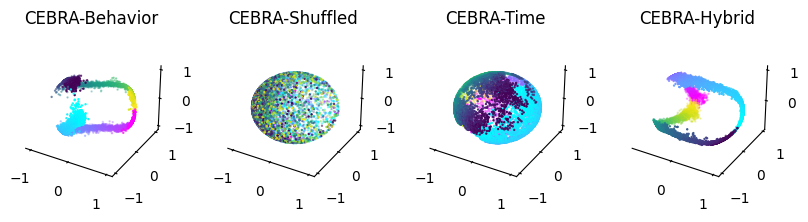

In [29]:
%matplotlib inline
fig = plt.figure(figsize=(10,2))

ax1 = plt.subplot(141, projection='3d')
ax2 = plt.subplot(142, projection='3d')
ax3 = plt.subplot(143, projection='3d')
ax4 = plt.subplot(144, projection='3d')

ax1=plot_hippocampus(ax1, cebra_posdir3, hippocampus_pos.continuous_index)
ax2=plot_hippocampus(ax2, cebra_posdir_shuffled3, hippocampus_pos.continuous_index)
ax3=plot_hippocampus(ax3, cebra_time3, hippocampus_pos.continuous_index)
ax4=plot_hippocampus(ax4, cebra_hybrid, hippocampus_pos.continuous_index)

ax1.set_title('CEBRA-Behavior')
ax2.set_title('CEBRA-Shuffled')
ax3.set_title('CEBRA-Time')
ax4.set_title('CEBRA-Hybrid')
plt.show()

### Hypothesis Testing: Train models with different hypothesis on position encoding of hippocampus.
- We will compare CEBRA-Behavior models trained with only position, only direction, both and the control models with shuffled behavior variables.

- Here, we use the set model dimension; in the paper we used 3-64 on the hippocampus data (and found a consistent topology across these dimensions).

- For the purpose of decoding later, we will use a splitted data (80% train, 20% test) and only use train set to train the models.

In [24]:
def split_data(data, test_ratio):

    split_idx = int(len(data)* (1-test_ratio))
    neural_train = data.neural[:split_idx]
    neural_test = data.neural[split_idx:]
    label_train = data.continuous_index[:split_idx]
    label_test = data.continuous_index[split_idx:]

    return neural_train.numpy(), neural_test.numpy(), label_train.numpy(), label_test.numpy()

neural_train, neural_test, label_train, label_test = split_data(hippocampus_pos, 0.2)

In [25]:
cebra_posdir_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=output_dimension,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_pos_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=output_dimension,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_dir_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=output_dimension,
                        max_iterations=max_iterations,
                        distance='cosine',
                        device='cuda_if_available',
                        verbose=True)

In [26]:
# Train CEBRA-Behavior models with position, direction variable or both.
# We get train set embedding and test set embedding.

cebra_posdir_model.fit(neural_train, label_train)
cebra_posdir_train = cebra_posdir_model.transform(neural_train)
cebra_posdir_test = cebra_posdir_model.transform(neural_test)

cebra_pos_model.fit(neural_train, label_train[:,0])
cebra_pos_train = cebra_pos_model.transform(neural_train)
cebra_pos_test = cebra_pos_model.transform(neural_test)

cebra_dir_model.fit(neural_train, label_train[:,1])
cebra_dir_train = cebra_dir_model.transform(neural_train)
cebra_dir_test = cebra_dir_model.transform(neural_test)

pos: -0.8804 neg:  6.3881 total:  5.5077 temperature:  1.0000: 100%|██████████| 10000/10000 [01:28<00:00, 112.75it/s]
pos: -0.8638 neg:  6.4725 total:  5.6087 temperature:  1.0000: 100%|██████████| 10000/10000 [01:28<00:00, 113.54it/s]
pos: -0.8244 neg:  6.4748 total:  5.6504 temperature:  1.0000: 100%|██████████| 10000/10000 [01:27<00:00, 113.68it/s]


### Train control models with shuffled behavior variables.

In [27]:
cebra_posdir_shuffled_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=output_dimension,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_pos_shuffled_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=output_dimension,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_dir_shuffled_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=output_dimension,
                        max_iterations=max_iterations,
                        distance='cosine',
                        device='cuda_if_available',
                        verbose=True)

In [ ]:
# Generate shuffled behavior labels for train set.
shuffled_posdir = np.random.permutation(label_train)
shuffled_pos = np.random.permutation(label_train[:,0])
shuffled_dir = np.random.permutation(label_train[:,1])

# Train the models with shuffled behavior variables and get train/test embeddings
cebra_posdir_shuffled_model.fit(neural_train, shuffled_posdir)
cebra_posdir_shuffled_train = cebra_posdir_shuffled_model.transform(neural_train)
cebra_posdir_shuffled_test = cebra_posdir_shuffled_model.transform(neural_test)

cebra_pos_shuffled_model.fit(neural_train, shuffled_pos)
cebra_pos_shuffled_train = cebra_pos_shuffled_model.transform(neural_train)
cebra_pos_shuffled_test = cebra_pos_shuffled_model.transform(neural_test)

cebra_dir_shuffled_model.fit(neural_train, shuffled_dir)
cebra_dir_shuffled_train = cebra_dir_shuffled_model.transform(neural_train)
cebra_dir_shuffled_test = cebra_dir_shuffled_model.transform(neural_test)

pos: -0.4548 neg:  6.5841 total:  6.1293 temperature:  1.0000:  22%|██▏       | 2188/10000 [00:19<01:09, 111.67it/s]

### Visualize embeddings from different hypothesis

In [ ]:
cebra_pos_all = cebra_pos_model.transform(hippocampus_pos.neural)
cebra_dir_all = cebra_dir_model.transform(hippocampus_pos.neural)
cebra_posdir_all = cebra_posdir_model.transform(hippocampus_pos.neural)

cebra_pos_shuffled_all = cebra_pos_shuffled_model.transform(hippocampus_pos.neural)
cebra_dir_shuffled_all = cebra_dir_shuffled_model.transform(hippocampus_pos.neural)
cebra_posdir_shuffled_all = cebra_posdir_shuffled_model.transform(hippocampus_pos.neural)

In [ ]:
fig=plt.figure(figsize=(9,6))
ax1=plt.subplot(231, projection = '3d')
ax2=plt.subplot(232, projection = '3d')
ax3=plt.subplot(233, projection = '3d')
ax4=plt.subplot(234, projection = '3d')
ax5=plt.subplot(235, projection = '3d')
ax6=plt.subplot(236, projection = '3d')

ax1=plot_hippocampus(ax1, cebra_pos_all, hippocampus_pos.continuous_index, gray=True)
ax2=plot_hippocampus(ax2, cebra_dir_all, hippocampus_pos.continuous_index, gray=True)
ax3=plot_hippocampus(ax3, cebra_posdir_all,hippocampus_pos.continuous_index, gray=True)
ax4=plot_hippocampus(ax4, cebra_pos_shuffled_all, hippocampus_pos.continuous_index, gray=True)
ax5=plot_hippocampus(ax5, cebra_dir_shuffled_all, hippocampus_pos.continuous_index, gray=True)
ax6=plot_hippocampus(ax6, cebra_posdir_shuffled_all, hippocampus_pos.continuous_index, gray=True)

ax1.set_title('position only')
ax2.set_title('direction only')
ax3.set_title('position+direction')
ax4.set_title('position, shuffled')
ax5.set_title('direction, shuffled')
ax6.set_title('pos+dir, shuffled')

def ax_lim(ax):
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_zlim(-1,1)

plt.show()

### Visualize the loss of models trained with different hypothesis

In [ ]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
ax.plot(cebra_posdir_model.state_dict_['loss'], c='deepskyblue', label = 'position+direction')
ax.plot(cebra_pos_model.state_dict_['loss'], c='deepskyblue', alpha = 0.3, label = 'position')
ax.plot(cebra_dir_model.state_dict_['loss'], c='deepskyblue', alpha=0.6,label = 'direction')
ax.plot(cebra_posdir_shuffled_model.state_dict_['loss'], c='gray', label = 'pos+dir, shuffled')
ax.plot(cebra_pos_shuffled_model.state_dict_['loss'], c='gray', alpha = 0.3, label = 'position, shuffled')
ax.plot(cebra_dir_shuffled_model.state_dict_['loss'],c='gray', alpha=0.6,label = 'direction, shuffled')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Iterations')
ax.set_ylabel('InfoNCE Loss')
plt.legend(bbox_to_anchor=(0.5,0.3), frameon = False )
plt.show()

### Decoding: we evaluate decoding performance of the different hypothesis models.

In [ ]:
# Define decoding function with kNN decoder. For a simple demo, we will use the fixed number of neighbors 36.

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
import sklearn.metrics

def decoding_pos_dir(emb_train, emb_test, label_train, label_test, n_neighbors=36):
    pos_decoder = KNeighborsRegressor(n_neighbors, metric = 'cosine')
    dir_decoder = KNeighborsClassifier(n_neighbors, metric = 'cosine')

    pos_decoder.fit(emb_train, label_train[:,0])
    dir_decoder.fit(emb_train, label_train[:,1])

    pos_pred = pos_decoder.predict(emb_test)
    dir_pred = dir_decoder.predict(emb_test)

    prediction =np.stack([pos_pred, dir_pred],axis = 1)

    test_score = sklearn.metrics.r2_score(label_test[:,:2], prediction)
    pos_test_err = np.median(abs(prediction[:,0] - label_test[:, 0]))
    pos_test_score = sklearn.metrics.r2_score(label_test[:, 0], prediction[:,0])

    return test_score, pos_test_err, pos_test_score

- Decode the position and direction from the trained hypothesis models

In [ ]:
cebra_posdir_decode = decoding_pos_dir(cebra_posdir_train, cebra_posdir_test, label_train, label_test)
cebra_pos_decode = decoding_pos_dir(cebra_pos_train, cebra_pos_test, label_train, label_test)
cebra_dir_decode = decoding_pos_dir(cebra_dir_train, cebra_dir_test, label_train, label_test)
cebra_posdir_shuffled_decode = decoding_pos_dir(cebra_posdir_shuffled_train, cebra_posdir_shuffled_test, label_train, label_test)
cebra_pos_shuffled_decode = decoding_pos_dir(cebra_pos_shuffled_train, cebra_pos_shuffled_test, label_train, label_test)
cebra_dir_shuffled_decode = decoding_pos_dir(cebra_dir_shuffled_train, cebra_dir_shuffled_test, label_train, label_test)


### Visualize the decoding results and loss - decoding performance

In [ ]:
fig = plt.figure(figsize=(10,4))
ax1= plt.subplot(121)
ax1.bar(np.arange(6),
        [cebra_posdir_decode[1], cebra_pos_decode[1], cebra_dir_decode[1],
         cebra_posdir_shuffled_decode[1], cebra_pos_shuffled_decode[1], cebra_dir_shuffled_decode[1]],
         width = 0.5, color = 'gray')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xticks(np.arange(6))
ax1.set_xticklabels(['pos+dir', 'pos', 'dir', 'pos+dir,\nshuffled', 'pos,\nshuffled', 'dir,\nshuffled'])
ax1.set_ylabel('Median err. [m]')

ax2 = plt.subplot(122)
ax2.scatter(cebra_posdir_model.state_dict_['loss'][-1],cebra_posdir_decode[1], s=50, c='deepskyblue', label = 'position+direction')
ax2.scatter(cebra_pos_model.state_dict_['loss'][-1],cebra_pos_decode[1], s=50, c='deepskyblue', alpha = 0.3, label = 'position_only')
ax2.scatter(cebra_dir_model.state_dict_['loss'][-1],cebra_dir_decode[1], s=50, c='deepskyblue', alpha=0.6,label = 'direction_only')
ax2.scatter(cebra_posdir_shuffled_model.state_dict_['loss'][-1],cebra_posdir_shuffled_decode[1], s=50, c='gray', label = 'pos+dir, shuffled')
ax2.scatter(cebra_pos_shuffled_model.state_dict_['loss'][-1],cebra_pos_shuffled_decode[1], s=50, c='gray', alpha = 0.3, label = 'position, shuffled')
ax2.scatter(cebra_dir_shuffled_model.state_dict_['loss'][-1],cebra_dir_shuffled_decode[1], s=50, c='gray', alpha=0.6,label = 'direction, shuffled')

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel('InfoNCE Loss')
ax2.set_ylabel('Decoding Median Err.')
plt.legend(bbox_to_anchor=(1,1), frameon = False )
plt.show()

## Persistent cohomology analysis with CEBRA embeddings of varying output dimensions:

### Train additional CEBRA-Behavior with dimensions 8, 16

In [ ]:
cebra_posdir8_model= CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=8,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)
cebra_posdir16_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=16,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

In [ ]:
cebra_posdir8_model.fit(hippocampus_pos.neural, hippocampus_pos.continuous_index.numpy())
cebra_posdir8 = cebra_posdir8_model.transform(hippocampus_pos.neural)

cebra_posdir16_model.fit(hippocampus_pos.neural, hippocampus_pos.continuous_index.numpy())
cebra_posdir16 = cebra_posdir16_model.transform(hippocampus_pos.neural)


### Plotting the results:


In [ ]:
fig = plt.figure(figsize = (10,3), dpi = 100)

ax1 = plt.subplot(131,projection='3d')
ax2 = plt.subplot(132, projection = '3d')
ax3 = plt.subplot(133, projection = '3d')

ax1=plot_hippocampus(ax1, cebra_posdir3, hippocampus_pos.continuous_index)
ax2=plot_hippocampus(ax2, cebra_posdir8, hippocampus_pos.continuous_index)
ax3=plot_hippocampus(ax3, cebra_posdir16, hippocampus_pos.continuous_index)

ax1.set_title('CEBRA-Dim 3')
ax2.set_title('CEBRA-Dim 8')
ax3.set_title('CEBRA-Dim 16')
plt.show()

## Topological Data Analysis:

### Get random 1000 points of embeddings and do persistent cohomology analysis upto H1

- note this requires the ripser package.
- If you previously installed DREiMac (such as running this notebook before, there are some dependency clashes with ripser, so you need to uninstall it first, and reinstall risper:

In [ ]:
!pip uninstall -y dreimac
!pip uninstall -y cebra
!pip uninstall -y ripser

In [ ]:
!pip install ripser
#Depending on your system, this can cause errors.
#Thus if issues please follow these instructions directly: https://pypi.org/project/ripser/
import ripser

- if you get the error `ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 80 from PyObject`, please delete the folders from DREiMac and run the cell above again.

In [ ]:
maxdim=1 ## Set to 2 to compute upto H2. The computing time is considerably longer. For quick demo upto H1, set it to 1.
np.random.seed(111)
random_idx=np.random.permutation(np.arange(len(cebra_posdir3)))[:1000]
topology_dimension = {}
for embedding in [cebra_posdir3, cebra_posdir8, cebra_posdir16]:
    ripser_output=ripser.ripser(embedding[random_idx], maxdim=maxdim, coeff=47)
    dimension = embedding.shape[1]
    topology_dimension[dimension] = ripser_output

### If you want to visualize the pre-computed persistent co-homology result:

- preloading saves quite a bit of time; to adapt to your own datasets please set topology_dimension and random_inx.

In [ ]:
preload=pd.read_hdf(os.path.join(CURRENT_DIR,'rat_demo_example_output.h5'))
topology_dimension = preload['topology']
topology_random_dimension = preload['topology_random']
random_idx = preload['embedding']['random_idx']
maxdim=2

In [ ]:
def plot_barcode(topology_result, maxdim):
    fig, axs = plt.subplots(maxdim+1, 1, sharex=True, figsize=(7, 8))
    axs[0].set_xlim(0,2)
    cocycle = ["Points", "Loops", "Voids"]
    for k in range(maxdim+1):
        bars = topology_result['dgms'][k]
        bars[bars == np.inf] = 10
        lc = (
            np.vstack(
                [
                    bars[:, 0],
                    np.arange(len(bars), dtype=int) * 6,
                    bars[:, 1],
                    np.arange(len(bars), dtype=int) * 6,
                ]
            )
            .swapaxes(1, 0)
            .reshape(-1, 2, 2)
        )
        line_segments = LineCollection(lc, linewidth=5, color="gray", alpha=0.5)
        axs[k].set_ylabel(cocycle[k], fontsize=20)
        if k == 0:
            axs[k].set_ylim(len(bars) * 6 - 120, len(bars) * 6)
        elif k == 1:
            axs[k].set_ylim(0, len(bars) * 1 - 30)
        elif k == 2:
            axs[k].set_ylim(0, len(bars) * 6 + 10)
        axs[k].add_collection(line_segments)
        axs[k].set_yticks([])
        if k == 2:
            axs[k].set_xticks(np.linspace(0, 2, 3), np
                              .linspace(0, 2, 3), fontsize=15)
            axs[k].set_xlabel("Lifespan", fontsize=20)

    return fig

In [ ]:
%matplotlib inline
for k in [3,8,16]:
    fig=plot_barcode(topology_dimension[k], maxdim)
    fig.suptitle(f'Dimension {k}')

In [ ]:
from persim import plot_diagrams

def read_lifespan(ripser_output, dim):
    dim_diff = ripser_output['dgms'][dim][:, 1] - ripser_output['dgms'][dim][:, 0]
    if dim == 0:
        return dim_diff[~np.isinf(dim_diff)]
    else:
        return dim_diff

def get_max_lifespan(ripser_output_list, maxdim):
    lifespan_dic = {i: [] for i in range(maxdim+1)}
    for f in ripser_output_list:
        for dim in range(maxdim+1):
            lifespan = read_lifespan(f, dim)
            lifespan_dic[dim].extend(lifespan)
    return [max(lifespan_dic[i]) for i in range(maxdim+1)], lifespan_dic

def get_betti_number(ripser_output, shuffled_max_lifespan):
    bettis=[]
    for dim in range(len(ripser_output['dgms'])):
        lifespans=ripser_output['dgms'][dim][:, 1] - ripser_output['dgms'][dim][:, 0]
        betti_d = sum(lifespans > shuffled_max_lifespan[dim] * 1.1)
        bettis.append(betti_d)
    return bettis
def plot_lifespan(topology_dgms, shuffled_max_lifespan, ax, label_vis, maxdim):
    plot_diagrams(
        topology_dgms,
        ax=ax,
        legend=True,
    )

    ax.plot(
        [
            -0.5,
            2,
        ],
        [-0.5 + shuffled_max_lifespan[0], 2 + shuffled_max_lifespan[0]],
        color="C0",
        linewidth=3,
        alpha=0.5,

    )
    ax.plot(
        [
            -0.5,
            2,
        ],
        [-0.5 + shuffled_max_lifespan[1], 2 + shuffled_max_lifespan[1]],
        color="orange",
        linewidth=3,
        alpha=0.5,

    )
    if maxdim == 2:
        ax.plot(
            [-0.50, 2],
            [-0.5 + shuffled_max_lifespan[2], 2 + shuffled_max_lifespan[2]],
            color="green",
            linewidth=3,
            alpha=0.5,
        )
    ax.set_xlabel("Birth", fontsize=15)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels([0, 1, 2])
    ax.tick_params(labelsize=13)
    if label_vis:
        ax.set_ylabel("Death", fontsize=15)
    else:
        ax.set_ylabel("")



In [ ]:
fig = plt.figure(figsize=(18,5))
for n, dim in enumerate([3,8,16]):
    shuffled_max_lifespan, lifespan_dic = get_max_lifespan(topology_random_dimension[dim], maxdim)
    ax = fig.add_subplot(1,3,n+1)
    ax.set_title(f'Dimension {dim}')
    plot_lifespan(topology_dimension[dim]['dgms'], shuffled_max_lifespan, ax, True, maxdim)
    print(f"Betti No. for dimension {dim}: {get_betti_number(topology_dimension[dim], shuffled_max_lifespan)}")

### Visualize topology-preserving circular coordinates from the first co-cycle.

- This requires the DREiMac codebase. Here, we show you how to install their package:

In [ ]:
!pip install git+https://github.com/ctralie/DREiMac.git@cdd6d02ba53c3597a931db9da478fd198d6ed00f

In [ ]:
from dreimac import CircularCoords

In [ ]:
%matplotlib inline

prime = 47
dimension = [3,8,16]
fig, axs = plt.subplots(1, 3, figsize=(10,3), dpi=200, subplot_kw={'projection': 'polar'})
label = hippocampus_pos.continuous_index[random_idx]
r_ind = label[:,1]==1
l_ind = label[:,2]==1
for i, embedding in enumerate([cebra_posdir3, cebra_posdir8, cebra_posdir16]):
    rat_emb=embedding[random_idx]
    cc = CircularCoords(rat_emb, 1000, prime = prime, )
    radial_angle=cc.get_coordinates(cocycle_idx=[0])
    r = np.ones(1000)
    right=axs[i].scatter(radial_angle[r_ind], r[r_ind], s=5, c = label[r_ind,0], cmap = 'cool')
    left=axs[i].scatter(radial_angle[l_ind], r[l_ind], s=5, c = label[l_ind,0], cmap = 'viridis')
    axs[i].set_title(f'Dimension {dimension[i]}')
plt.show()

### Visualize Polar coordinate (radial angle) vs. Position

###### if you want to preload our data, run the following, otherwise skip this cell:

In [ ]:
cebra_pos3 = preload['embedding'][3]
cebra_pos8 = preload['embedding'][8]
cebra_pos16 = preload['embedding'][16]

In [ ]:
radial_angles = {}
for i, embedding in enumerate([cebra_pos3, cebra_pos8, cebra_pos16]):
    rat_emb=embedding[random_idx]
    cc = CircularCoords(rat_emb, 1000, prime = prime, )
    out=cc.get_coordinates()
    radial_angles[dimension[i]] = out

In [ ]:
%matplotlib inline
for k in radial_angles.keys():
    fig=plt.figure(figsize=(7,6))
    plt.subplots_adjust(wspace=0.3)
    fig.suptitle(f'Dimension {k}')
    ax1=plt.subplot(121)
    ax1.scatter(radial_angles[k][r_ind], label[r_ind,0], s=1, c = 'gray')
    ax1.set_xlabel('Radial angle [rad]')
    ax1.set_ylabel('Position [m]')
    ax2=plt.subplot(122)
    ax2.scatter(radial_angles[k][l_ind], label[l_ind,0], s=1, c= 'gray')
    ax2.set_xlabel('Radial angle [rad]')
    ax2.set_ylabel('Position [m]')
plt.show()

### Compute linear correlation between computed coordinate and the position

In [ ]:
import sklearn.linear_model
def lin_regression(radial_angles, labels):
    def _to_cartesian(radial_angles):
        x = np.cos(radial_angles)
        y = np.sin(radial_angles)
        return np.vstack([x,y]).T
    cartesian = _to_cartesian(radial_angles)
    lin = sklearn.linear_model.LinearRegression()
    lin.fit(cartesian, labels)

    return lin.score(cartesian, labels)

In [ ]:
for k in radial_angles.keys():
    print(f'Dimension {k} Cycle angle into position')
    print(f'Right R2: {lin_regression(radial_angles[k][r_ind], label[r_ind,0])}')
    print(f'Left R2: {lin_regression(radial_angles[k][l_ind], label[l_ind,0])}')
    print(f'Total R2: {lin_regression(radial_angles[k], label[:,0])}')

### Interactive plot to explore co-cycles and circular coordinates.
- Top left panel is a lifespan diagram of persistent co-homology analysis.
- Bottom left panel is a visualization of the first 2 dimensions of the used 1000 embedding points.
- Bottom right panel is a circular coordinate obtained from the co-cycles.
- For more information: https://github.com/ctralie/DREiMac

In [ ]:
## change the embedding to use. Here, we look at 3D embedding for posdir3 (position+dir, dim 3):
X=cebra_posdir3[random_idx]

%matplotlib notebook
rl_stack=np.vstack([X[r_ind], X[l_ind]])
label_stack = np.vstack([label[r_ind], label[l_ind]])

c1 = plt.get_cmap('cool')
C1 = c1(label[r_ind,0])
c2 = plt.get_cmap('viridis')
C2 = c2(label[l_ind,0])

C = np.vstack([C1,C2])

def plot_circles(ax):
    ax.scatter(rl_stack[:, 0], rl_stack[:, 1], c=C)


cc = CircularCoords(rl_stack, 1000, prime = prime)
cc.plot_torii(C, coords_info=2, plots_in_one=3, lowerleft_plot=plot_circles)
